# Setting

## 한글 글꼴 설치

In [16]:
# !apt-get install -y fonts-nanum
# !fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [2]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 13.1 MB/s eta 0:00:00


In [5]:
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.1/31.1 MB 40.6 MB/s eta 0:00:0000:0100:01


## Library

In [17]:
import random
import pandas as pd
import numpy as np
import os

from PIL import Image
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic') 
import seaborn as sns

import cv2 as cv

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

In [7]:
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.models import resnet18
from torchvision import transforms

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## 하이퍼파라미터

In [8]:
CFG = {
    'IMG_HEIGHT_SIZE':64,
    'IMG_WIDTH_SIZE':224,
    'EPOCHS':30,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':256,
    'NUM_WORKERS':1, # 본인의 GPU, CPU 환경에 맞게 설정
    'SEED':41
}

## Fixed Random Seed

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

# Load Data Set

## Load Train Set

In [10]:
df = pd.read_csv('./data/train.csv')

In [11]:
print(df.shape)
df.head()

(76888, 3)


,id,img_path,label
0,TRAIN_00000,./train/TRAIN_00000.png,빨간색
1,TRAIN_00001,./train/TRAIN_00001.png,머
2,TRAIN_00002,./train/TRAIN_00002.png,차차
3,TRAIN_00003,./train/TRAIN_00003.png,써
4,TRAIN_00004,./train/TRAIN_00004.png,놓치다


# EDA

## Length Label


In [12]:
df['len'] = df['len'] = df['label'].str.len()

In [13]:
df_len_count = pd.DataFrame(df['len'].value_counts())
df_len_count.reset_index(inplace=True)
df_len_count.columns = ['len', 'len_count']

display(df_len_count)

,len,len_count
0,2,28631
1,1,23703
2,3,13514
3,4,9988
4,5,1026
5,6,26


<AxesSubplot: xlabel='len', ylabel='len_count'>

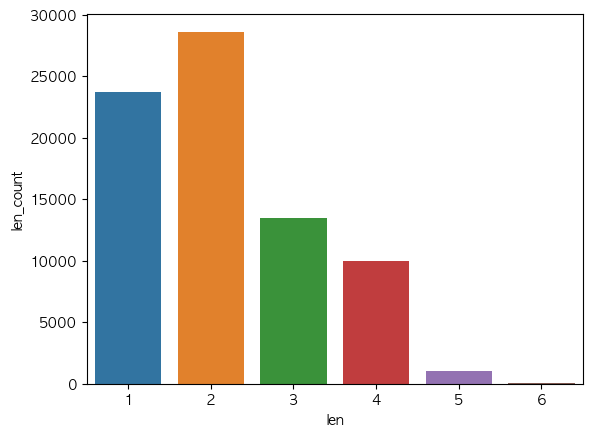

In [18]:
# label (글자)의 길이가 불균형
sns.barplot(data=df_len_count, x='len', y='len_count')

## Show Sample

In [43]:
def show_image(Image, Picture_Name):
    plt.imshow(Image)
    plt.title(Picture_Name)
    plt.show()

In [44]:
def sample_df_by_len(df, n_sample, n_len, use_frac=False):

  cond = (df['len']==n_len)

  df = df.loc[cond]

  if use_frac == True:

    df = df.sample(frac=n_sample)

  else:

    df = df.sample(n=n_sample)

  return df

In [45]:
def show_sample_image(df, n_sample, n_len):

  df = sample_df_by_len(df, n_sample, n_len)

  for img, label in zip('./data'+df['img_path'][3:], df['label']):

    img = cv.imread(img)
    show_image(img, label)

### Len 1

In [46]:
# 이미지 사이즈가 일정하지 않음
# 배경에 노이즈가 존재
# 흑백 이미지
show_sample_image(df=df, n_sample=3, n_len=1)

### Len 2

In [36]:
# 기울러진 글씨가 존재
show_sample_image(df=df, n_sample=3, n_len=2)

### Len 3

In [37]:
show_sample_image(df=df, n_sample=3, n_len=3)

### Len 4

In [38]:
show_sample_image(df=df, n_sample=3, n_len=4)

### Len 5

In [39]:
show_sample_image(df=df, n_sample=3, n_len=5)

### Len 6

In [40]:
show_sample_image(df=df, n_sample=3, n_len=6)

## Count label by Len

In [41]:
def show_count_label(df, n_len, n_show):

  df = sample_df_by_len(df=df, n_sample=1.0, n_len=n_len, use_frac=True)

  df = pd.DataFrame(df['label'].value_counts())
  df.reset_index(inplace=True)

  df.columns = ['label', 'count_label']
  df.sort_values(by='count_label', ascending=False, inplace=True)

  many_df = df.head(n_show)
  little_df = df.tail(n_show)

  fig, ax = plt.subplots(ncols=2, figsize=(13, 6))

  sns.barplot(data=many_df, x='count_label', y='label', ax=ax[0])
  ax[0].set_title(f'label 길이 {n_len}의 label 개수 상위 {n_show}')

  sns.barplot(data=little_df, x='count_label', y='label', ax=ax[1])
  ax[1].set_title(f'label 길이 {n_len}의 label 개수 하위 {n_show}')

  plt.show()

### Len 1

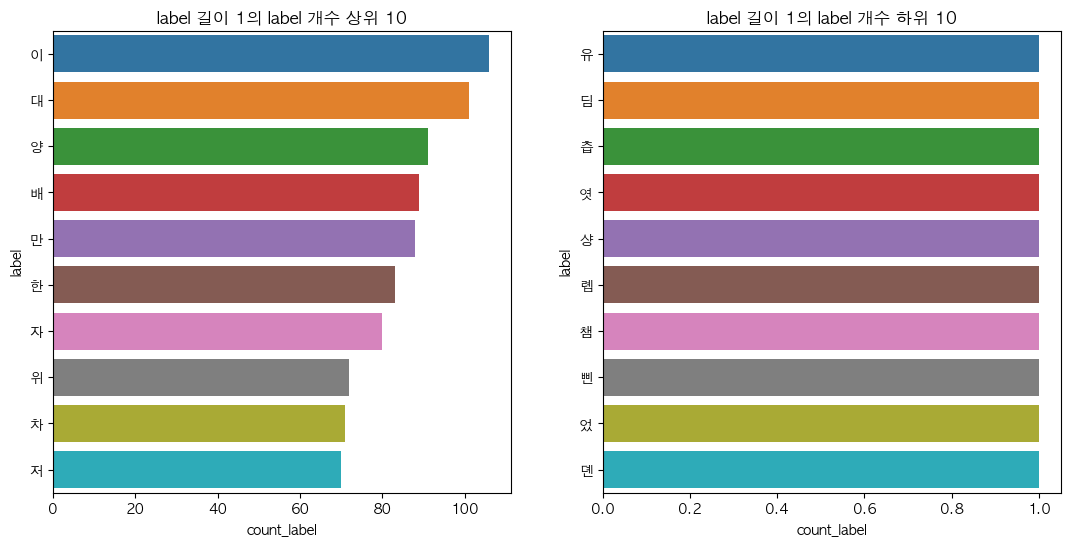

In [42]:
# label 개수가 1개인 데이터 존재
show_count_label(df, 1, 10)

### Len 2

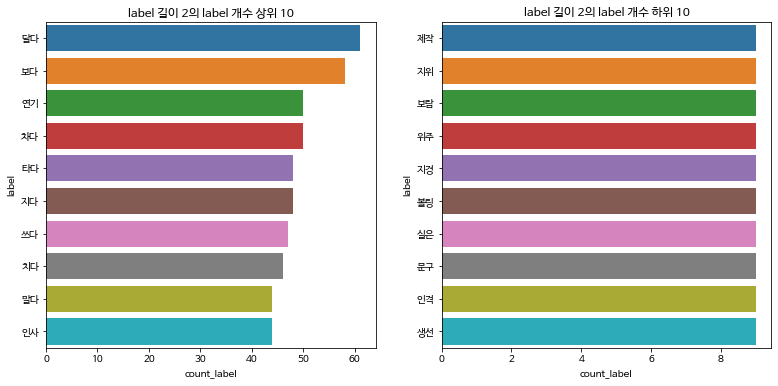

In [90]:
show_count_label(df, 2, 10)

### Len 3

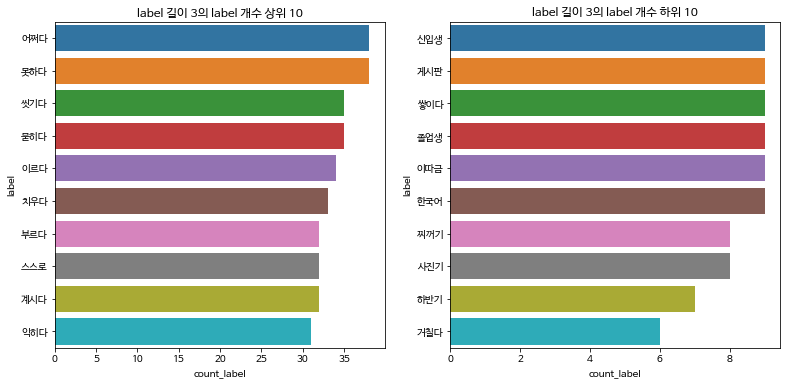

In [91]:
show_count_label(df, 3, 10)

### Len 4

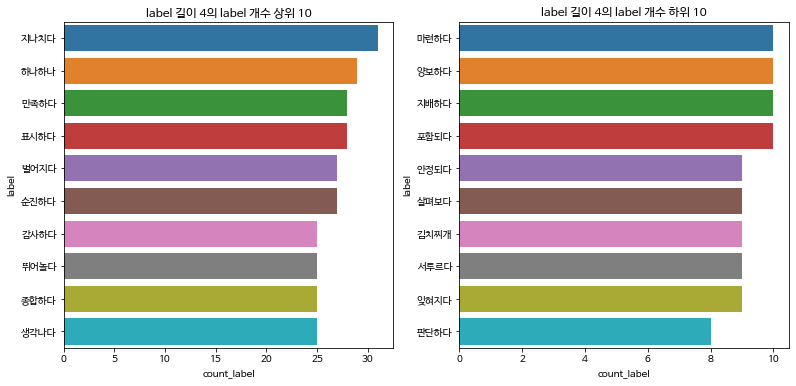

In [92]:
show_count_label(df, 4, 10)

### Len 5

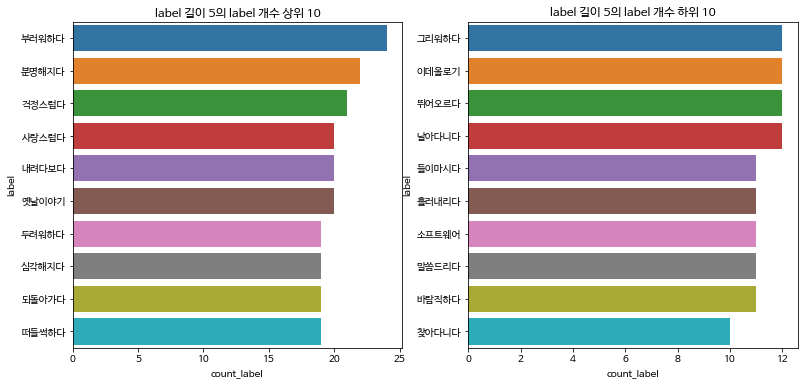

In [93]:
show_count_label(df, 5, 10)

### Len 6

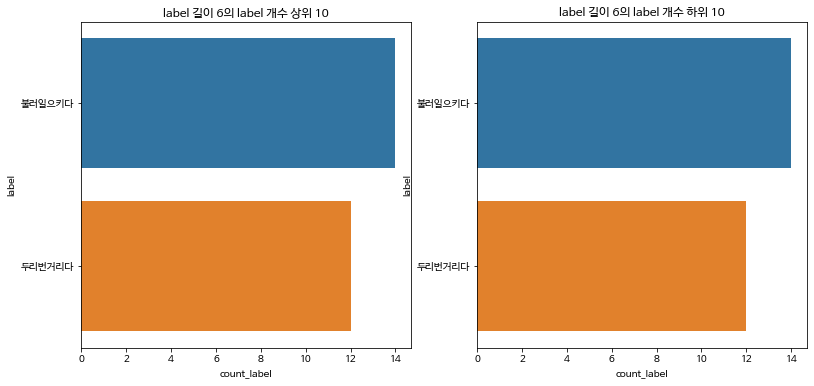

In [94]:
# label이 '불러일으키다' & '두리번거리다' 밖에 없음
show_count_label(df, 6, 10)

## Check Image Size 

In [107]:
X_size = []
Y_size = []

for path in tqdm(df['img_path']):

  image = Image.open(path)

  image_size = image.size

  X = image_size[0]
  Y = image_size[-1]

  X_size.append(X)
  Y_size.append(Y)

df['X'] = X_size
df['Y'] = Y_size

  0%|          | 0/76888 [00:00<?, ?it/s]

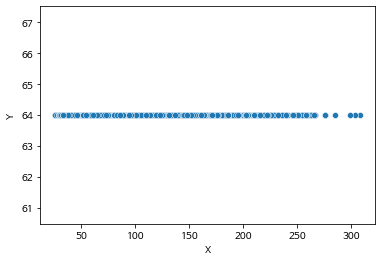

In [110]:
# 세로 길이는 64로 통일
sns.scatterplot(data=df, x='X', y='Y')

In [121]:
df['X'].max()

308

가장 긴 가로 길이 : 308
가장 짧은 가로 길이 : 26
평균 가로 길이 : 87.358


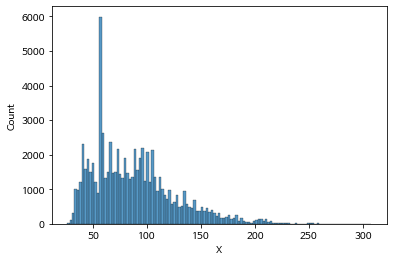

In [126]:
# 가로 길이가 50 후반인 데이터가 많다
print('가장 긴 가로 길이 : {}'.format(df['X'].max()))
print('가장 짧은 가로 길이 : {}'.format(df['X'].min()))
print('평균 가로 길이 : {:.3f}'.format(df['X'].mean()))
sns.histplot(data=df, x='X')

In [117]:
df_X_Size = pd.DataFrame(df['X'].value_counts())
df_X_Size.columns = ['X_Size_Count']
df_X_Size

,X_Size_Count
58,3922
59,1633
57,1503
100,1168
93,1092
...,...
299,1
308,1
242,1
230,1
